# Bank Marketing Campaign Analysis

This notebook analyzes a bank marketing campaign dataset and improves a classification model to predict customer subscription ("y" variable). The focus is on data cleaning, handling class imbalance, and building a robust model.

## 1. Import Libraries

In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [12]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression
from xgboost import XGBClassifier
from sklearn.metrics import classification_report, accuracy_score, confusion_matrix,roc_curve, roc_auc_score
from imblearn.over_sampling import SMOTE
import matplotlib.pyplot as plt
import seaborn as sns

## 2. Load Dataset

In [3]:
# Load the dataset
df_orig = pd.read_csv("/content/drive/MyDrive/Job Search/Portfolio/Final Portfolio Projects/Bank_Marketing/Coding/bank.csv", delimiter=';')
df_orig.head(10)

,age,job,marital,education,default,balance,housing,loan,contact,day,month,duration,campaign,pdays,previous,poutcome,y
0,30,unemployed,married,primary,no,1787,no,no,cellular,19,oct,79,1,-1,0,unknown,no
1,33,services,married,secondary,no,4789,yes,yes,cellular,11,may,220,1,339,4,failure,no
2,35,management,single,tertiary,no,1350,yes,no,cellular,16,apr,185,1,330,1,failure,no
3,30,management,married,tertiary,no,1476,yes,yes,unknown,3,jun,199,4,-1,0,unknown,no
4,59,blue-collar,married,secondary,no,0,yes,no,unknown,5,may,226,1,-1,0,unknown,no
5,35,management,single,tertiary,no,747,no,no,cellular,23,feb,141,2,176,3,failure,no
6,36,self-employed,married,tertiary,no,307,yes,no,cellular,14,may,341,1,330,2,other,no
7,39,technician,married,secondary,no,147,yes,no,cellular,6,may,151,2,-1,0,unknown,no
8,41,entrepreneur,married,tertiary,no,221,yes,no,unknown,14,may,57,2,-1,0,unknown,no
9,43,services,married,primary,no,-88,yes,yes,cellular,17,apr,313,1,147,2,failure,no


In [4]:
# Making a copy
data = df_orig.copy()

## 3. Data Cleaning

### Key Steps:
- Add a new feature to indicate previous contact.
- Encode the target variable (`y`).

In [5]:
# Encode target variable `y` as binary: 'no' -> 0, 'yes' -> 1
data['y'] = data['y'].map({'no': 0, 'yes': 1})

# Add a flag for previous contact
data['was_contacted_before'] = (data['pdays'] != -1).astype(int)

# One-hot encode categorical variables
categorical_features = ['job', 'marital', 'education', 'default', 'housing', 'loan', 'contact', 'month', 'poutcome']
data_encoded = pd.get_dummies(data, columns=categorical_features, drop_first=True)
data_encoded.head()

,age,balance,day,duration,campaign,pdays,previous,y,was_contacted_before,job_blue-collar,...,month_jul,month_jun,month_mar,month_may,month_nov,month_oct,month_sep,poutcome_other,poutcome_success,poutcome_unknown
0,30,1787,19,79,1,-1,0,0,0,False,...,False,False,False,False,False,True,False,False,False,True
1,33,4789,11,220,1,339,4,0,1,False,...,False,False,False,True,False,False,False,False,False,False
2,35,1350,16,185,1,330,1,0,1,False,...,False,False,False,False,False,False,False,False,False,False
3,30,1476,3,199,4,-1,0,0,0,False,...,False,True,False,False,False,False,False,False,False,True
4,59,0,5,226,1,-1,0,0,0,True,...,False,False,False,True,False,False,False,False,False,True


## 4. Train-Test Split

### Why?
Splitting ensures the model is tested on unseen data to measure generalizability.

In [6]:
# Split the data into features (X) and target (y)
X = data_encoded.drop('y', axis=1)
y = data_encoded['y']

# Train-test split 80/20
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=314, stratify=y)

## 5. Address Class Imbalance

### Why?
The target variable is imbalanced, which led me to poor predictions for the minority class ("yes").

In [7]:
# Apply SMOTE to handle class imbalance
smote = SMOTE(random_state=314)
X_resampled, y_resampled = smote.fit_resample(X, y)

# Resample train-test split
X_train_resampled, X_test_resampled, y_train_resampled, y_test_resampled = train_test_split(
    X_resampled, y_resampled, test_size=0.2, random_state=42, stratify=y_resampled
)

## 6. Model Training

### Model: Random Forest
- A robust, ensemble-based classifier.

In [10]:
# Initialize models
models = {
    "Logistic Regression": LogisticRegression(max_iter=1000, random_state=314),
    "Random Forest": RandomForestClassifier(random_state=314, n_estimators=100),
    "XGBoost": XGBClassifier(use_label_encoder=False, eval_metric='logloss', random_state=314)
}

In [11]:
# Train each model
for name, model in models.items():
    model.fit(X_train_resampled, y_train_resampled)
    print(f"{name} trained successfully!")

/usr/local/lib/python3.11/dist-packages/sklearn/linear_model/_logistic.py:465: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


Logistic Regression trained successfully!
Random Forest trained successfully!
XGBoost trained successfully!


/usr/local/lib/python3.11/dist-packages/xgboost/core.py:158: UserWarning: [15:55:36] WARNING: /workspace/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)


In [14]:
# Evaluation
for name, model in models.items():
    y_pred = model.predict(X_test_resampled)  # Adjusted from X_test_final to X_test
    y_proba = model.predict_proba(X_test_resampled)[:, 1]  # For ROC AUC

    # Metrics
    accuracy = accuracy_score(y_test_resampled, y_pred)
    auc_score = roc_auc_score(y_test_resampled, y_proba)
    print(f"\n{name} Performance:")
    print("Accuracy:", accuracy)
    print("ROC AUC:", auc_score)
    print("Classification Report:\n", classification_report(y_test_resampled, y_pred))


Logistic Regression Performance:
Accuracy: 0.9125
ROC AUC: 0.9675546875
Classification Report:
               precision    recall  f1-score   support

           0       0.91      0.92      0.91       800
           1       0.92      0.91      0.91       800

    accuracy                           0.91      1600
   macro avg       0.91      0.91      0.91      1600
weighted avg       0.91      0.91      0.91      1600


Random Forest Performance:
Accuracy: 0.940625
ROC AUC: 0.9876281250000001
Classification Report:
               precision    recall  f1-score   support

           0       0.93      0.95      0.94       800
           1       0.95      0.93      0.94       800

    accuracy                           0.94      1600
   macro avg       0.94      0.94      0.94      1600
weighted avg       0.94      0.94      0.94      1600


XGBoost Performance:
Accuracy: 0.939375
ROC AUC: 0.98660625
Classification Report:
               precision    recall  f1-score   support

          

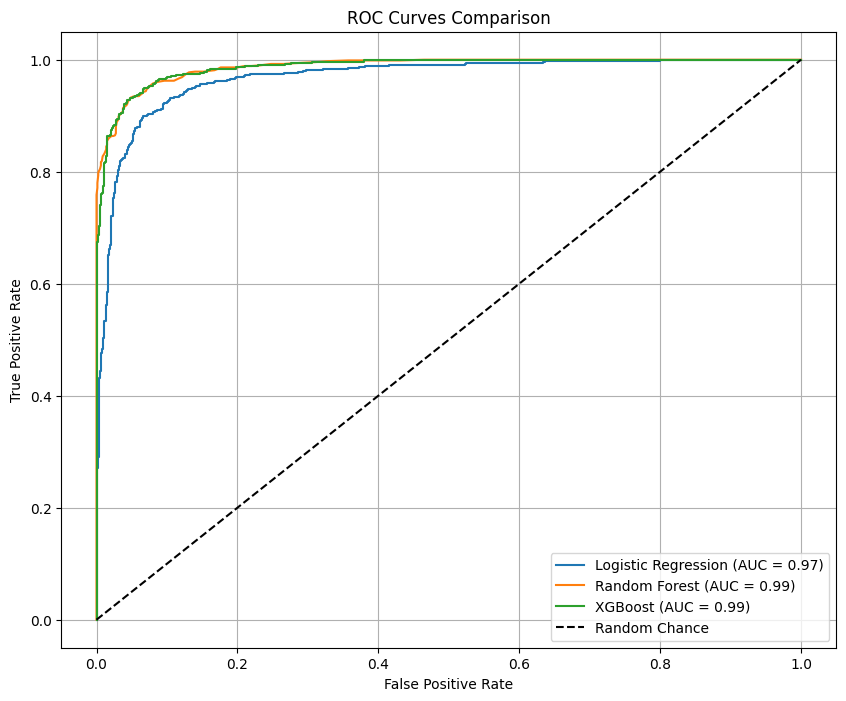

In [15]:
# Plot ROC Curves for all models
plt.figure(figsize=(10, 8))
for name, model in models.items():
    y_proba = model.predict_proba(X_test_resampled)[:, 1]
    fpr, tpr, _ = roc_curve(y_test_resampled, y_proba)
    plt.plot(fpr, tpr, label=f'{name} (AUC = {roc_auc_score(y_test_resampled, y_proba):.2f})')

plt.plot([0, 1], [0, 1], 'k--', label='Random Chance')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curves Comparison')
plt.legend()
plt.grid(True)
plt.show()

In [ ]:
# Train Random Forest model
#model = RandomForestClassifier(random_state=314, n_estimators=100)
#model.fit(X_train_resampled, y_train_resampled)

## 7. Model Evaluation

In [ ]:
# Make predictions
#y_pred = model.predict(X_test_resampled)

# Evaluate the model
#accuracy = accuracy_score(y_test_resampled, y_pred)
#classification_rep = classification_report(y_test_resampled, y_pred)
#conf_matrix = confusion_matrix(y_test_resampled, y_pred, normalize='true')

#print("Accuracy:", accuracy)
#print("\nClassification Report:\n", classification_rep)
#print("\nConfusion Matrix:\n", conf_matrix)

In [ ]:
# Plot Confusion Matrix
#plt.figure(figsize=(8, 6))
#sns.heatmap(conf_matrix, annot=True, cmap='Blues', fmt='.2f',
            #xticklabels=['Negative', 'Positive'], yticklabels=['Negative', 'Positive'])
#plt.xlabel('Predicted')
#plt.ylabel('Actual')
#plt.title('Confusion Matrix')
#plt.show()

## 8. Results and Insights

### Results (from Random Forest after SMOTE):
- **Accuracy:** ~94%
- **Precision for "yes":** ~95%
- **Recall for "yes":** ~94%

### Overall, model seems to have done well with SMOTE method.

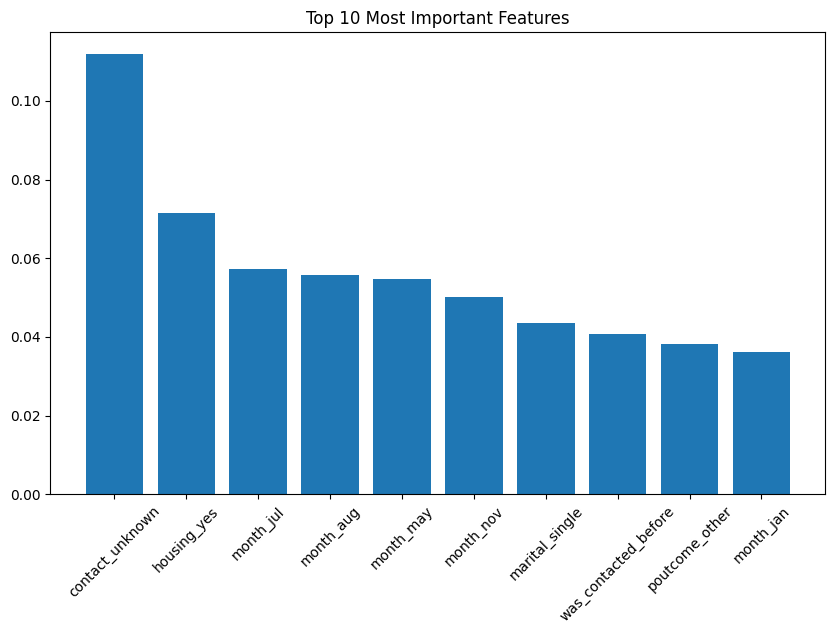

In [17]:
# Get feature importances from the trained model
feature_importance = model.feature_importances_
feature_names = X_train.columns

# Sort by importance
sorted_idx = np.argsort(feature_importance)[::-1]

# Plot the top 10 features
plt.figure(figsize=(10, 6))
plt.bar(range(10), feature_importance[sorted_idx[:10]], align="center")
plt.xticks(range(10), np.array(feature_names)[sorted_idx[:10]], rotation=45)
plt.title("Top 10 Most Important Features")
plt.show()

In [ ]:
# Compare subscription rates for different past campaign outcomes
success_rates = data.groupby("poutcome")["y"].mean()

print(success_rates)


In [ ]:
# Compare subscription rates by contact method
contact_success_rates = data.groupby("contact")["y"].mean()

print(contact_success_rates)


In [ ]:
# Compare subscription rates by month
month_success_rates = data.groupby("month")["y"].mean().sort_values(ascending=False)

print(month_success_rates)


In [ ]:
y_probs = model.predict_proba(X_test_resampled)[:, 1]  # Probabilities for the positive class




In [ ]:
X_test_resampled["subscription_probability"] = y_probs
sorted_customers = X_test_resampled.sort_values(by="subscription_probability", ascending=False)
print(sorted_customers.head(10))  # Top 10 highest probability customers